In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Getting Data

In [4]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_134.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_77.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_2.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_4.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_24.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=256)

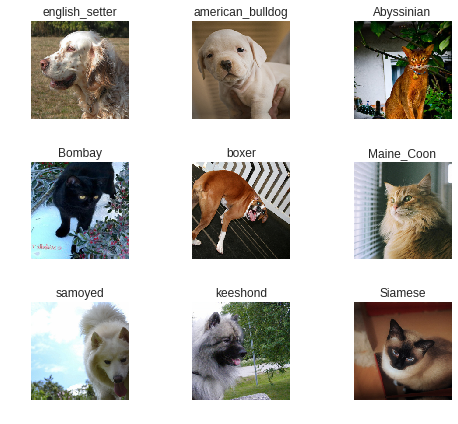

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Data Augmentation
Side note: I tried with and without augmentation and got better results using it.

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, bs=128, 
        ds_tfms=get_transforms(do_flip=True, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0),size=224, num_workers=4)

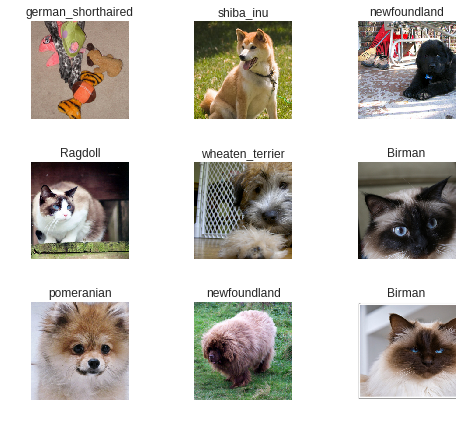

In [13]:
data.show_batch(rows=3, figsize=(7,6))

## Using NOT pretrained resnet34

In [8]:
#saving models in google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'
path1 = Path(base_dir + 'data/pets')

Mounted at /content/gdrive


In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate,pretrained = False)

In [0]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,3.959400,3.873905,0.970907
2,3.762296,3.457651,0.914750
3,3.564171,3.402137,0.896482
4,3.369163,3.104066,0.840325


In [0]:
#running with more epochs
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,error_rate
1,4.073698,3.657606,0.963464
2,4.012495,3.574781,0.951962
3,3.962032,3.535888,0.945196
4,3.908499,3.491604,0.922192
5,3.836394,3.419297,0.894452
6,3.752391,3.372648,0.909337
7,3.673062,3.254115,0.884303
8,3.585046,3.210309,0.879567
9,3.487627,3.186817,0.868742
10,3.398961,3.075029,0.859946


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6500c5d9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f6500c5d9b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", 

We can observe overfitting following epoch 30. Unfreezing the layers and training again

In [0]:
#changing number of epochs and training again
learn.fit_one_cycle(30)

In [0]:
learn.save(path1/'untrained-stage-1')

In [0]:
learn.load(path1/'untrained-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (5912 items)
[Category chihuahua, Category pug, Category Siamese, Category yorkshire_terrier, Category german_shorthaired]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (5912 items)
[Image (3, 500, 331), Image (3, 222, 300), Image (3, 375, 500), Image (3, 334, 500), Image (3, 500, 361)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList
y: CategoryList (1478 items)
[Category chihuahua, Category Egyptian_Mau, Category Russian_Blue, Category american_bulldog, Category Russian_Blue]...
Path: /root/.fastai/data/oxford-iiit-pet/images
x: ImageItemList (1478 items)
[Image (3, 225, 300), Image (3, 240, 300), Image (3, 500, 417), Image (3, 500, 375), Image (3, 442, 500)]...
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, 

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


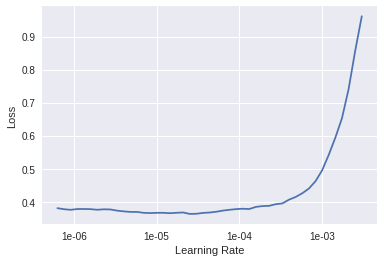

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [0]:
#Training with discriminative learning rate
learn.fit_one_cycle(20, max_lr=slice(5e-6,1e-5))
learn.save(path1/'untrained-stage-2-v2')

epoch,train_loss,valid_loss,error_rate
1,0.350025,1.136169,0.310555
2,0.345887,1.135754,0.308525
3,0.351682,1.136277,0.311908
4,0.348511,1.135397,0.308525
5,0.348884,1.137654,0.312585
6,0.351382,1.135130,0.312585
7,0.356708,1.134850,0.307848
8,0.350706,1.134586,0.306495
9,0.347569,1.135109,0.309878
10,0.348157,1.132121,0.309878


## Finding top bad matches

In [0]:
learn.load(path1/'untrained-stage-2-v2');

FileNotFoundError: ignored

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

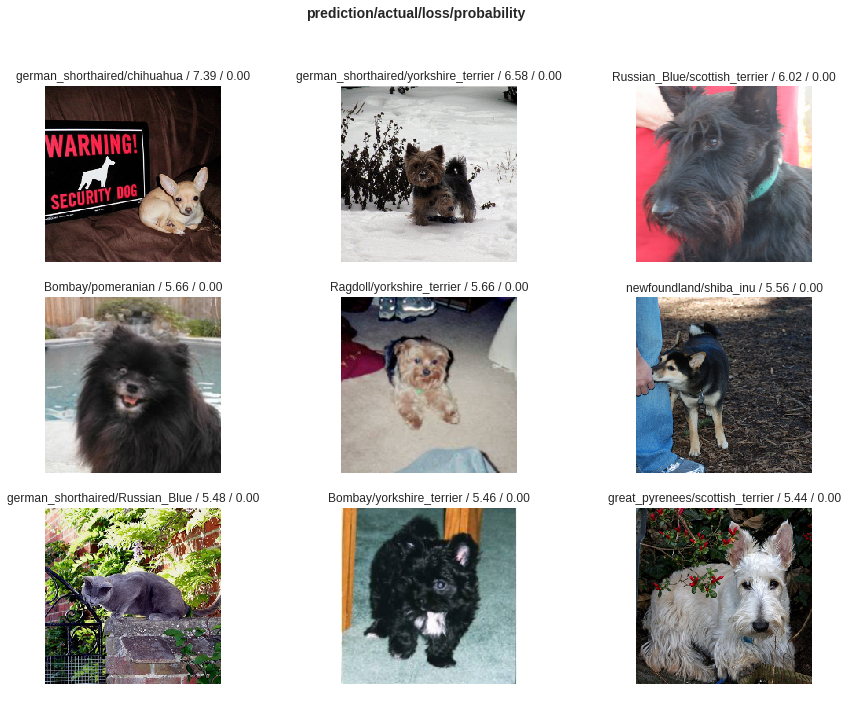

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
interp.most_confused(min_val=2)

## Trying Data Augmentation

In [0]:
slice(1e-4,1e-3)

slice(0.0001, 0.001, None)

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, bs=256, 
        ds_tfms=get_transforms(do_flip=True, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0),size=224, num_workers=4)

In [0]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [0]:
import re
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224,128, 'zeros')

AssertionError: ignored

Going to try:
1. Data Augmentation
2. Data cleaning


Changing the parameters of all the fully connected layers instead of only final layer it will improve results.
I think you should try data augmentation first before try to freeze some layers in the classifier or use dropout 